# Script to detect faces and landmarks in images using dlib

*  **Importing libraries**
*  **detectFace(impath) predicts facial landmarks and saves them to a file( which this function returns as string)**
*  **alignAndcrop(impath, landmarkpath) returns the cropped image after aligning the eyes**
* **detectAndaligncrop(impath) detects faces in an image, saves landmarks, and aligns and crops images with eyes horizontal**

### Following: https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/
#### conda environment(detect_face) configuration:
    - python 2
    - dlib (just google installation for conda) 
    - pip install --upgrade imutils
    - opencv (conda-forge)
    - matplotlib (to visualise inline)

In [1]:
import sys
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
args={"shape_predictor":"shape_predictor_68_face_landmarks.dat"}

In [3]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])

Function to detect faces and save in a txt file{imname_landmarks1.txt} after detector and predictor are defined

In [63]:
def detectFace(impath):
    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread(impath)
#     image = imutils.resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # detect faces in the grayscale image
    rects = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        print(shape.shape)
        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # show the face number
        cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        basePath=imageTouse.split('.')[0]
        lmpath=basePath+"_landmarks"+str(i+1)+".txt"
        text_file = open(lmpath, "w")
        for (x, y) in shape:
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
            text_file.write(str(x)+' '+str(y)+'\n')
        text_file.close()
    # cv2.imshow("im", image)
    # cv2.waitKey(1000)
#     print 'These are the detected faces and the landmarks, which have been written to : ', lmpath
#     print imageTouse.shape,
    print 'landmarks written to: ', lmpath
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    return lmpath

(68, 2)
landmarks written to:  /media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN001/out-001_landmarks1.txt


'/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN001/out-001_landmarks1.txt'

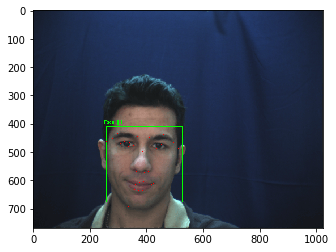

In [64]:
detectFace(imageTouse)

## Cropping and aligning face

#### Helper functions: (see details in *tryAlignmentWarping.ipynb*)

In [42]:
# Read points from text files in directory
def readPoints(path) :
    pointsArray = [];
    points = [];   
    print(path)
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(float(x)), int(float(y))))
    pointsArray.append(points)
    return pointsArray;

# Read all jpg images in folder.
def readImages(path) :
    imagesArray = [];
    img = cv2.imread(path);
    img = np.float32(img)/255.0;
    imagesArray.append(img);
    return imagesArray;
                
# Compute similarity transform given two sets of two points, OpenCV requires 3 pairs of corresponding points, we are faking the third one.
def similarityTransform(inPoints, outPoints) :
    s60 = math.sin(60*math.pi/180);
    c60 = math.cos(60*math.pi/180);  
  
    inPts = np.copy(inPoints).tolist();
    outPts = np.copy(outPoints).tolist();
    
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0];
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1];
    
    inPts.append([np.int(xin), np.int(yin)]);
    
    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0];
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1];
    
    outPts.append([np.int(xout), np.int(yout)]);
    
    tform = cv2.estimateRigidTransform(np.array([inPts]), np.array([outPts]), False);
    
    return tform;

#### Function to align image

The code is in such a form so that refactoring allows calculating average landmarks for multiple images

In [43]:
def alignAndcrop(img_abs_path, landmark_abs_path):
    # Dimensions of output image
    w = 112;
    h = 112;
    landmark_path=landmark_abs_path
    allPoints = readPoints(landmark_path);
    images = readImages(img_abs_path);
    # Eye corners
    eyecornerDst = [ (np.int(0.3 * w ), np.int(h / 3)), (np.int(0.7 * w ), np.int(h / 3)) ];
    imagesNorm = [];
    pointsNorm = [];
#     print allPoints[0]
    # Add boundary points for delaunay triangulation
    boundaryPts = np.array([(0,0), (w/2,0), (w-1,0), (w-1,h/2), ( w-1, h-1 ), ( w/2, h-1 ), (0, h-1), (0,h/2) ]);
    n = len(allPoints[0]);
    numImages = len(images)
    for i in xrange(0, numImages):
        points1 = allPoints[i];
        # Corners of the eye in input image
        eyecornerSrc  = [ allPoints[i][36], allPoints[i][45] ] ;
        # Compute similarity transform
        tform = similarityTransform(eyecornerSrc, eyecornerDst);
#         print tform
        # Apply similarity transformation
        img = cv2.warpAffine(images[i], tform, (w,h));
#         plt.imshow(img)
        # Apply similarity transform on points
        points2 = np.reshape(np.array(points1), (68,1,2));        
        points = cv2.transform(points2, tform);
        points = np.float32(np.reshape(points, (68, 2)));
        pointsNorm.append(points);
        imagesNorm.append(img);
#     print (pointsNorm[0])
#     plt.imshow(imagesNorm[0]) 
    # Output image
    output=imagesNorm[0]
    writeToFile=False
    if writeToFile==True:
        pass
#         cv2.imwrite('cropped.bmp',output*255)
#     cv2.imshow('image', output)
#     cv2.waitKey(0)
    return output

In [ ]:
An issue to resolve is taking care of the datatype of the image, it works for the bmp images I extracted from the 

/media/amogh/Stuff/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S999/003/S999_003_00000055_landmarks.txt
image shape is:  (112, 112, 3) some values are [0.60958946 0.58667284 0.8155944 ]


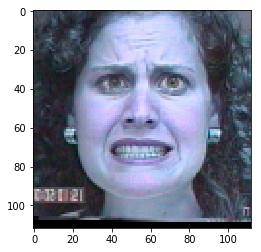

In [44]:
impath2use='/media/amogh/Stuff/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S999/003/S999_003_00000055.png'
lmpath2use='/media/amogh/Stuff/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S999/003/S999_003_00000055_landmarks.txt'
# impath2use='/home/amogh/cmu/notebooks/face.jpg'
# lmpath2use='/home/amogh/cmu/notebooks/landmarks1.txt'
im=alignAndcrop(impath2use,lmpath2use)
print 'image shape is: ', im.shape, 'some values are', im[50][50]
plt.imshow(im)

In [45]:
def detectAndaligncrop(impath):
    lmpath=detectFace(impath)
    finalimage=alignAndcrop(impath,lmpath2use)
    print 'final cropped image: ', finalimage.shape
#     plt.imshow(finalimage)

In [61]:
# imageTouse='/media/amogh/Stuff/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S999/003/S999_003_00000055.png'
imageTouse='/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN001/out-001.bmp'

(68, 2)
landmarks written to:  /media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN001/out-001_landmarks1.txt
/media/amogh/Stuff/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S999/003/S999_003_00000055_landmarks.txt
final cropped image:  (112, 112, 3)


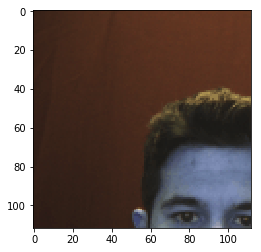

In [62]:
detectAndaligncrop(imageTouse)